In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import IPython.display
IPython.display.display(IPython.display.HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('./../src/')
from manuscript import flow_sankey as sankey
from manuscript import datasets, inout, export


import itertools
import scipy.stats
import statsmodels.stats.multitest
import statannotations.Annotator

pd.options.display.max_columns = 200
mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["font.family"] = "Arial"

fonts = inout.get_resource_path('fonts')
for f in os.listdir(fonts):
    if f.endswith(".ttf"):
        mpl.font_manager.fontManager.addfont(f"{fonts}/{f}")
        
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"


def dump_table(df, name):
    export.full_frame(
        user, 
        f'{outfolder}/{name}', 
        df, 
        index=True,
        date=True
    )

def dump_figure(name):
    export.image(
        user,
        f'{outfolder}/{name}',
    )

In [2]:
DISCH_PALETTE = [
    "tab:blue", #home
    "lightseagreen", #rehab
    "beige", #snf
    "gold",#ltach
    "orange",#hospice
    "crimson",#died 
]

In [3]:
user = 'general'     # defines top hierarchy of output folder
outfolder = '10_VAP_transitions'    # name of notebook

In [4]:
data = pd.read_csv(
    inout.get_material_path('general/05_join_clusters_umap/05_data_umap_clusters_220908_1554.csv.gz'), 
    index_col=0
)

In [5]:
# match old naming

data.Binary_outcome.replace({1: "Died", 0: 'Alive'}, inplace=True)

data.Discharge_disposition = data.Discharge_disposition.astype("category")
data.Discharge_disposition = data.Discharge_disposition.cat.reorder_categories([
    'Home', 
    'Rehab', 
    'SNF', 
    'LTACH',
    'Hospice', 
    'Died'
])

data = data.rename(columns={
    'Patient_id': 'patient',
    'ICU_stay': 'stay',
    'ICU_day': 'day',
    'clusters': 'cluster'
})

# Ensure order
data.sort_values(["patient", "stay", "day"], inplace=True)

## Create intermediate data

A dataframe for each day around each VAP episode: in which clusters were the patients.

At the same time, check if any other pneumonia episode is overlapping

In [6]:
dfs = []
for day in range(-2, 8):
    days = data.day[data.Episode_category.eq("VAP") & data.Episode_etiology.ne("Viral")] + day
    days = days[days > 0]
    idx = (
        data.patient[days.index].astype(str) 
        + "/" + data.stay[days.index].astype(str) 
        + "/" + days.astype(str)
    )
    idx = idx[idx.isin(data.index)]
    df = pd.DataFrame({
        "cluster": data.cluster[idx].values,
        "next_cluster": data.next_cluster[idx].values,
        "episode_type": data.Episode_category[idx.index].values,
        "day": day
    }, index=idx.index)
    if day != 0:
        overlapping = data.loc[idx, ["Episode_category"]]
        overlapping["current_ep"] = idx.index.values
        overlapping = overlapping.loc[overlapping.Episode_category.isin(["CAP", "HAP", "VAP"]), :]
        if overlapping.shape[0] > 0:
            n_overlapping = (~overlapping.Episode_category.isna()).sum()
            print(f"{n_overlapping} overlapping episodes on day {day}")
            for i, row in overlapping.iterrows():
                print(f"On day {day} of {row.current_ep} VAP episode there was {i} episode")
            print()
    full_idx = data.index[data.Episode_category.eq("VAP") & data.Episode_etiology.ne("Viral")]
    df = df.reindex(full_idx)
    df.loc[full_idx[~full_idx.isin(idx.index)], "day"] = day
    df.loc[full_idx[~full_idx.isin(idx.index)], "episode_type"] = "VAP"
    df.loc[full_idx, "cured"] = data.Episode_is_cured[full_idx]
    df.loc[full_idx, "patient"] = data.patient[full_idx]
    df.loc[full_idx, "stay"] = data.stay[full_idx]
    df.loc[full_idx, "outcome"] = data.Binary_outcome[full_idx]
    dfs.append(df)
df = pd.concat(dfs)

1 overlapping episodes on day 7
On day 7 of 887/1/13 VAP episode there was 887/1/20 episode



In [7]:
df.shape

(2790, 8)

# Does Cured VAP lead to significantly favorable transitions?

We will take all VAP episodes, and summarize transition deltas from day 0 to day X (7 or before).

Do it for 3 cured categories, and test statistical differences

#### Add mortality data

In [8]:
df.loc[df.next_cluster.eq(-1), "next_cluster"] = np.nan

In [9]:
cluster_mortality = pd.read_csv(
    inout.get_material_path('general/04_clustering/Similarity-cluster_mortality_220908_1540.csv.gz'), 
    index_col=0
)

In [10]:
cluster_mortality['clusters'] = cluster_mortality['index'] + 1

In [11]:
cluster_mortality = cluster_mortality[['clusters', 'mortality']]

In [12]:
cluster_mortality = cluster_mortality.set_index("clusters")

In [13]:
df.loc[~df.cluster.isna(), "mortality"] = cluster_mortality.mortality[df.cluster[~df.cluster.isna()]].values

In [14]:
df.loc[~df.next_cluster.isna(), "next_mortality"] = cluster_mortality.mortality[
    df.next_cluster[~df.next_cluster.isna()]
].values

In [15]:
df.loc[
    df.next_cluster.isna() & df.outcome.eq("Alive"),
    "next_mortality"
] = 0

In [16]:
df.loc[
    df.next_cluster.isna() & df.outcome.eq("Died"),
    "next_mortality"
] = 1

In [17]:
df = df.loc[df.day >= 0].copy()

In [18]:
df["mortality_delta"] = df.next_mortality - df.mortality

In [19]:
df.mortality_delta.fillna(0, inplace=True)

In [20]:
df["episode_start"] = df.index

In [21]:
def vap_transitions(df, day):
    df = df.loc[df.day <= day]
    stat_df = df.groupby(["cured", "episode_start"]).mortality_delta.sum().reset_index()
    stat_results = []
    for d1, d2 in itertools.combinations(stat_df.cured.unique(), 2):
        days1 = stat_df.mortality_delta[stat_df.cured.eq(d1)]
        days2 = stat_df.mortality_delta[stat_df.cured.eq(d2)]
        if days1.size == 0 or days2.size == 0:
            continue
        pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
        stat_results.append([d1, d2, days1.size, days2.size, pval])
    stat_results = pd.DataFrame(stat_results, columns=["group1", "group2",
                                                       "group1_size", "group2_size", "pval"])
    stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]
    stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]
    pairs = []
    for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))
    
    fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
    sns.boxplot(
        data=stat_df, 
        x="cured",
        y="mortality_delta", 
        ax=ax, 
        saturation=1, 
        palette=[DISCH_PALETTE[0], DISCH_PALETTE[3], DISCH_PALETTE[-1]],
        linewidth=1
    )
    for a in ax.collections:
        if isinstance(a, mpl.collections.PatchCollection):
            # remove line surround each box
            a.set_linewidth(0)
    ax.set_ylabel("Sum of transitions", size=16)
    ax.set_xlabel("")
    ax.tick_params(axis="x", labelsize=14)
    # ax.set_xticklabels(["non-COVID", "COVID"], size=16)
    # ax.legend(loc="upper left", title="Outcome", frameon=False, fontsize=14, title_fontsize=12)
    # ax.legend_.set_bbox_to_anchor((1, 0.8))
    ax.set_title(f"Distribution of sum of transitions for first {day} days after episode", size=16)
    annotator = statannotations.Annotator.Annotator(
        ax, 
        pairs, 
        data=stat_df, 
        x="cured",
        y="mortality_delta", 
        verbose=False
    )
    annotator._verbose = False
    annotator.configure(line_width=1)
    annotator.set_custom_annotations([f"q={x:.2e}".replace("-", "–") for x in stat_results_sign.pval_adj])
    annotator.annotate();
    return ax

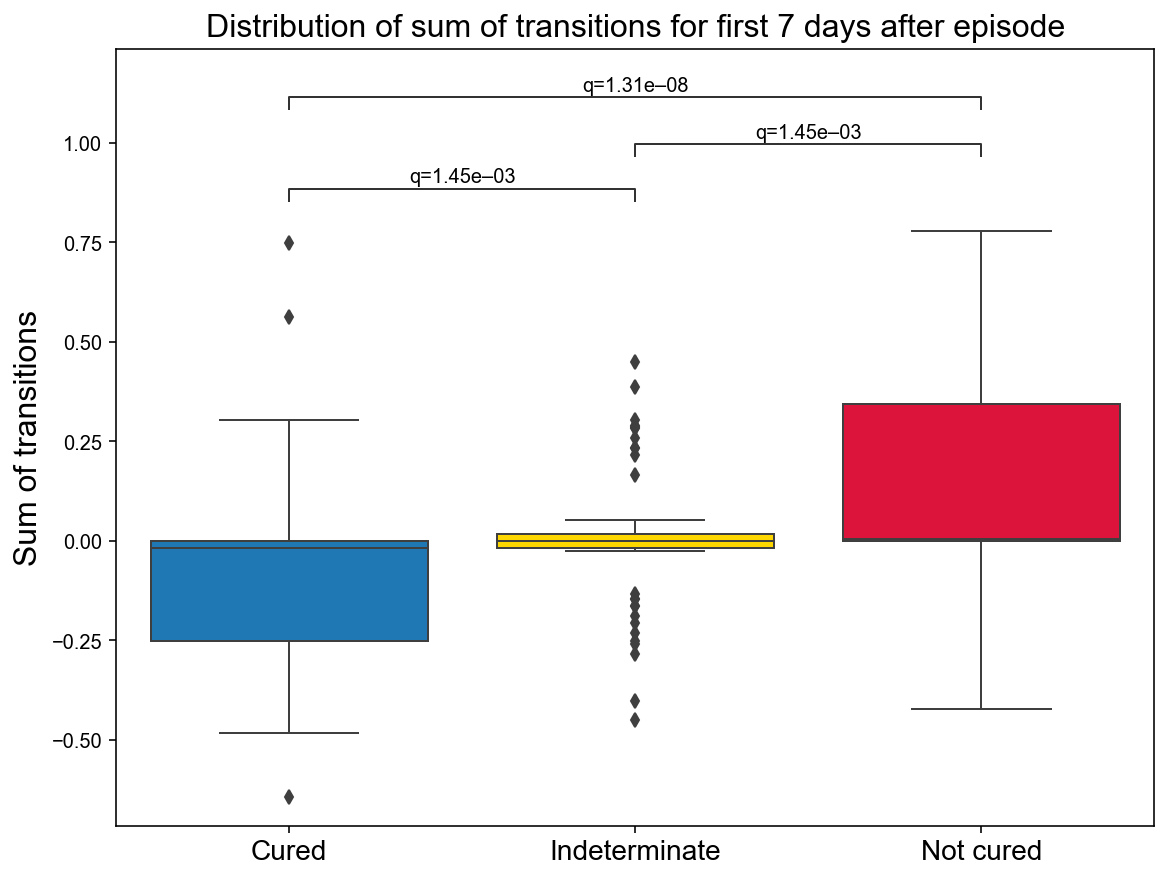

In [22]:
vap_transitions(df, 7)
dump_figure("vap_sum_of_trans_7days.pdf")

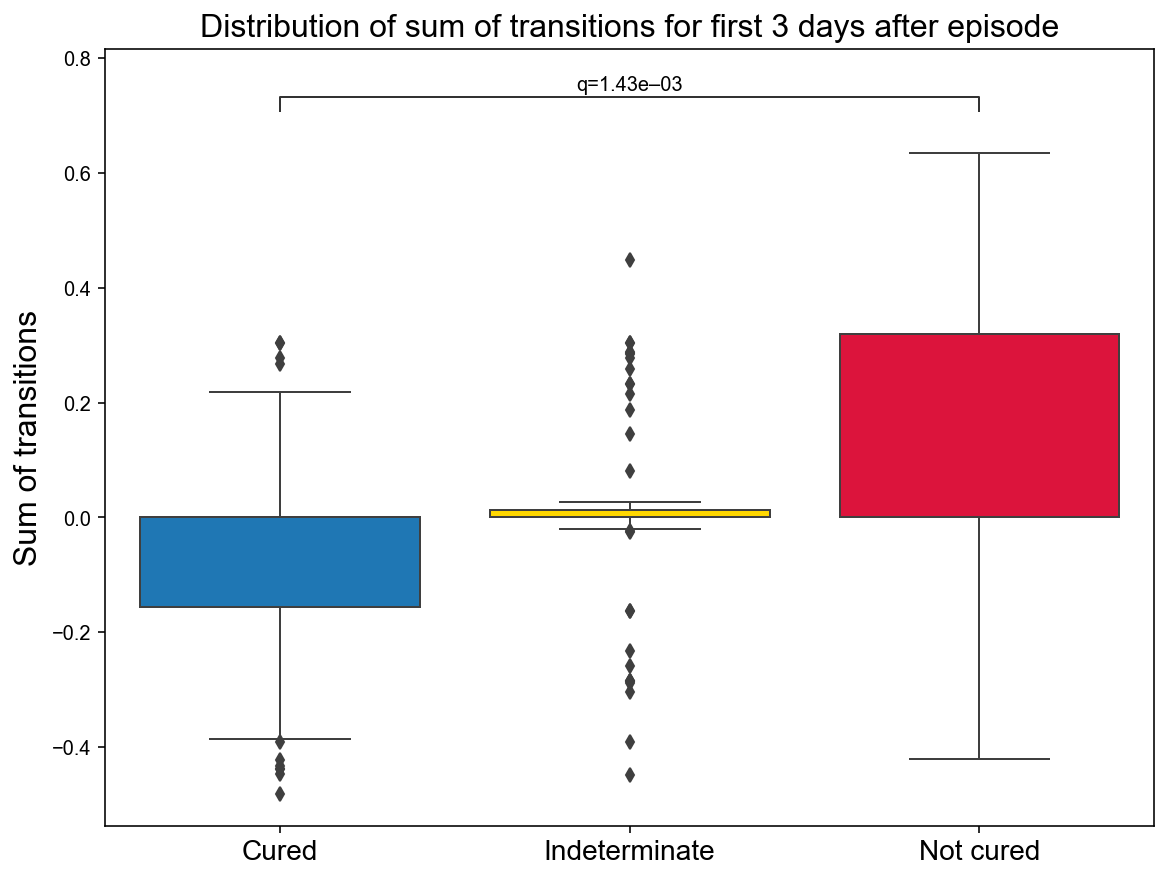

In [23]:
vap_transitions(df, 3)
dump_figure("vap_sum_of_trans_3days.pdf")

<AxesSubplot:title={'center':'Distribution of sum of transitions for first 4 days after episode'}, ylabel='Sum of transitions'>

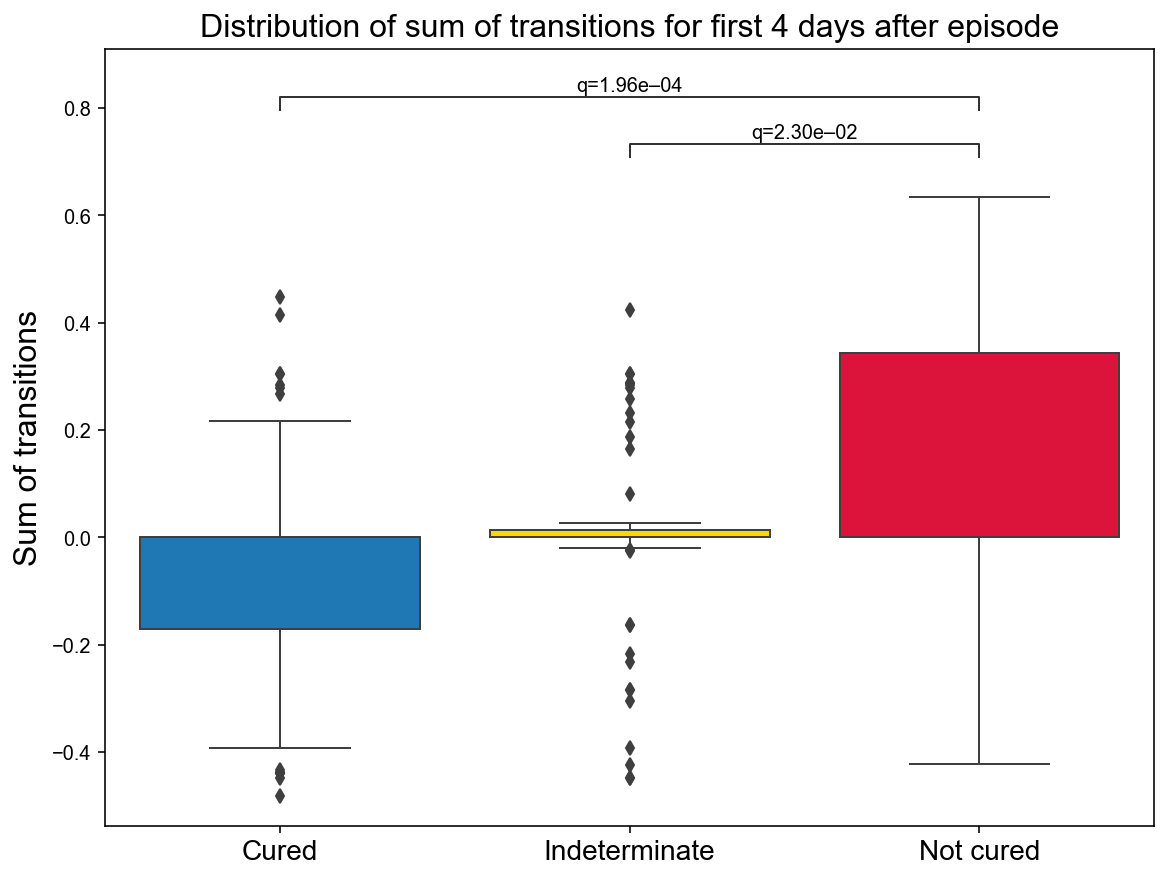

In [24]:
vap_transitions(df, 4)

<AxesSubplot:title={'center':'Distribution of sum of transitions for first 5 days after episode'}, ylabel='Sum of transitions'>

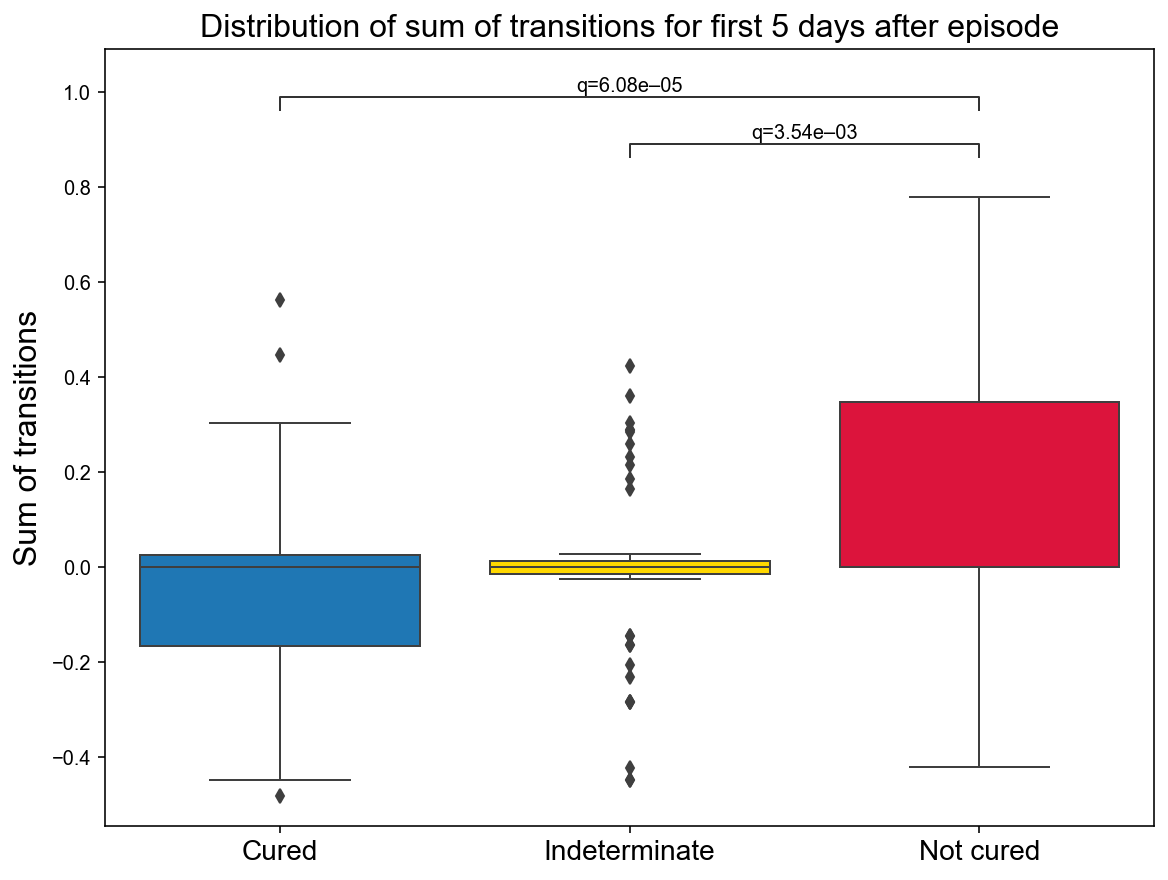

In [25]:
vap_transitions(df, 5)

<AxesSubplot:title={'center':'Distribution of sum of transitions for first 6 days after episode'}, ylabel='Sum of transitions'>

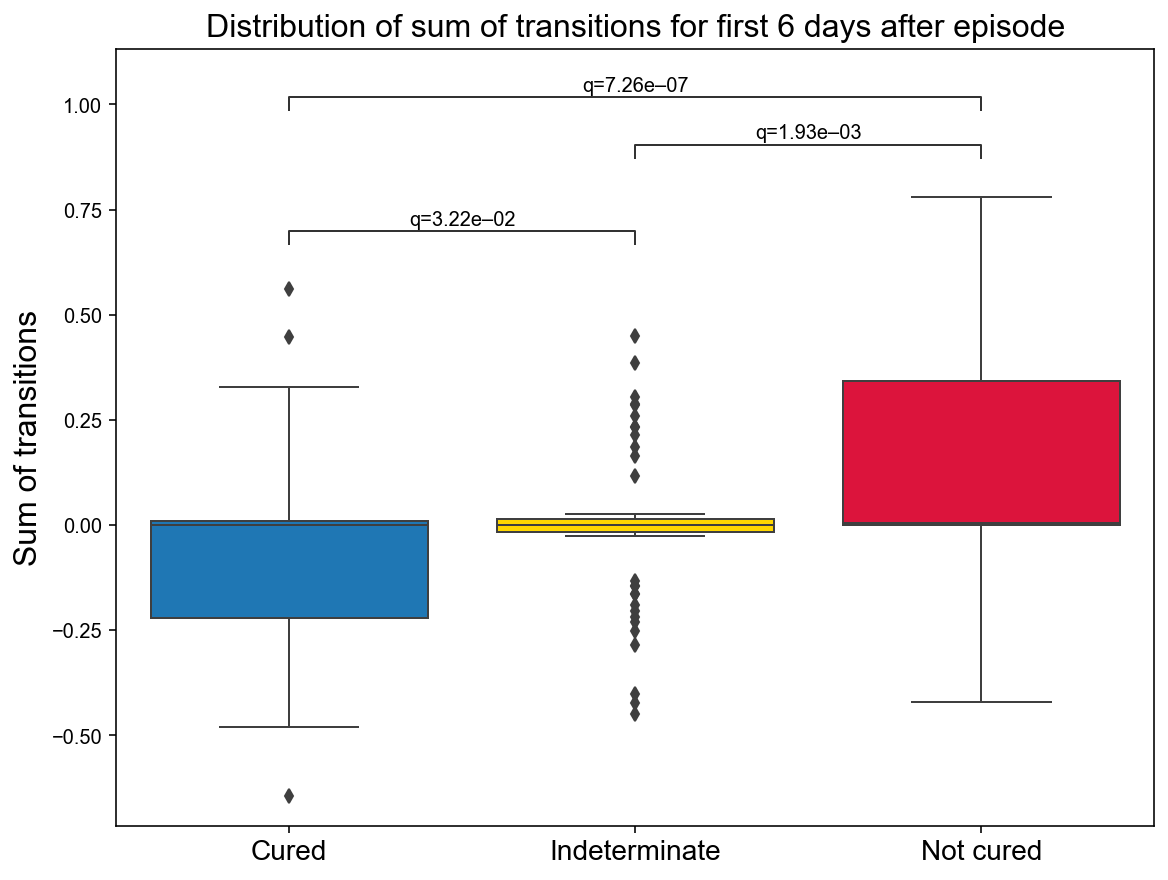

In [26]:
vap_transitions(df, 6)

## Plot distribution of transition sums per day

In [27]:
def transtion_sums(df, day):
    CURED_MAP = {
        "Cured": 1,
        "Indeterminate": 0,
        "Not cured": -1
    }
    df = df.loc[df.day <= day]
    df = df.groupby(["cured", "episode_start"]).mortality_delta.sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
    ax.scatter(
        df.mortality_delta,
        df.cured.map(CURED_MAP) + np.random.uniform(low=-0.2, high=0.2, size=df.shape[0]),
        c=[mpl.cm.tab10(x + 1) for x in df.cured.map(CURED_MAP)]
    )
    ax.set_xlabel("Sum of transitions", size=16)
    ax.set_title(f"Distribution of sum of transitions for first {day} days after episode", size=16)
    ax.set_yticks(list(CURED_MAP.values()))
    ax.set_yticklabels(list(CURED_MAP.keys()), size=16)
    return ax

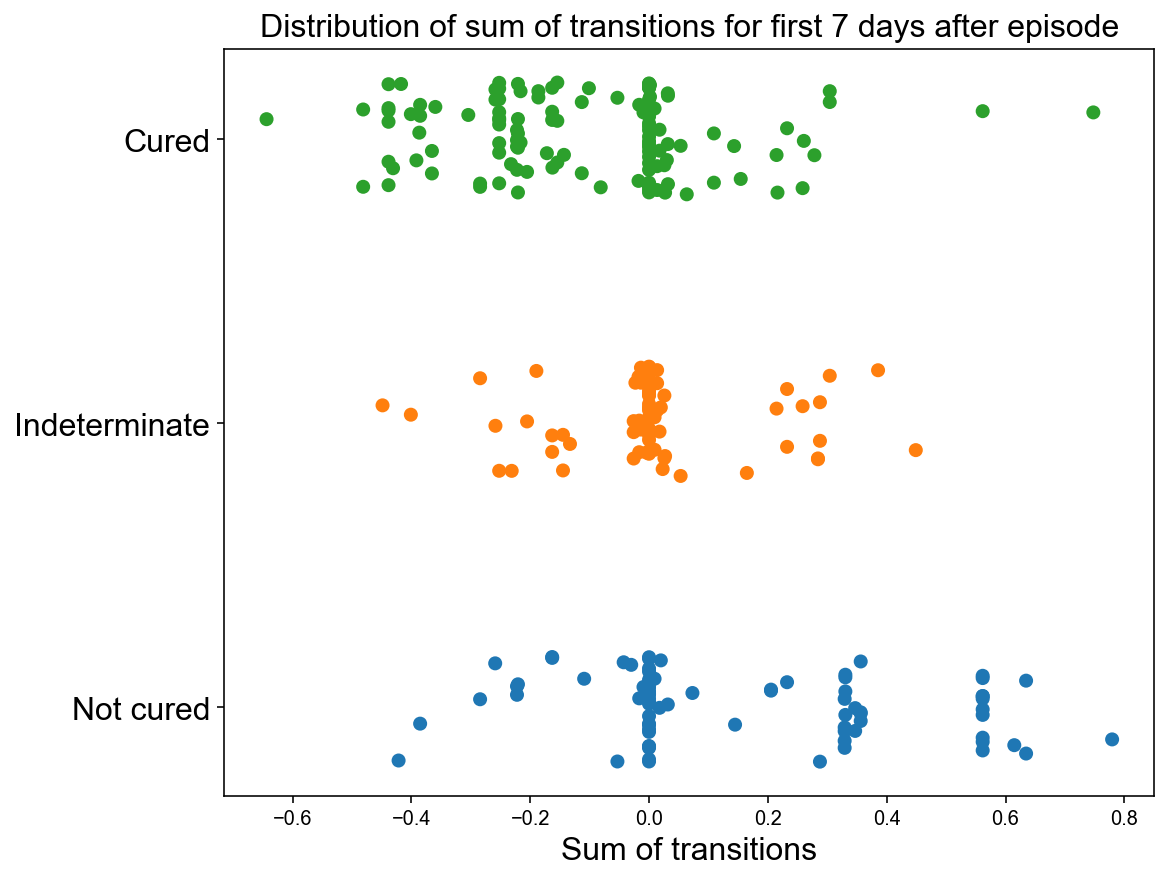

In [28]:
transtion_sums(df, 7);

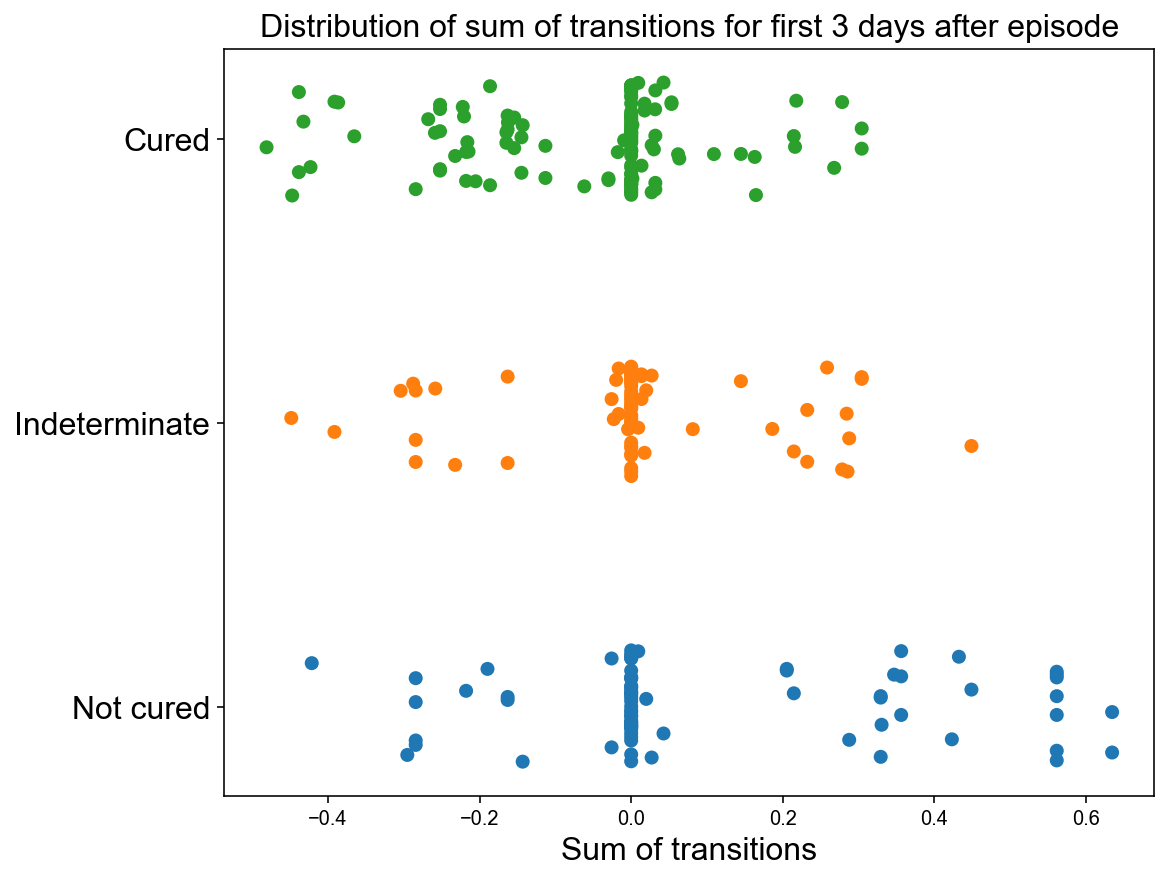

In [29]:
transtion_sums(df, 3);

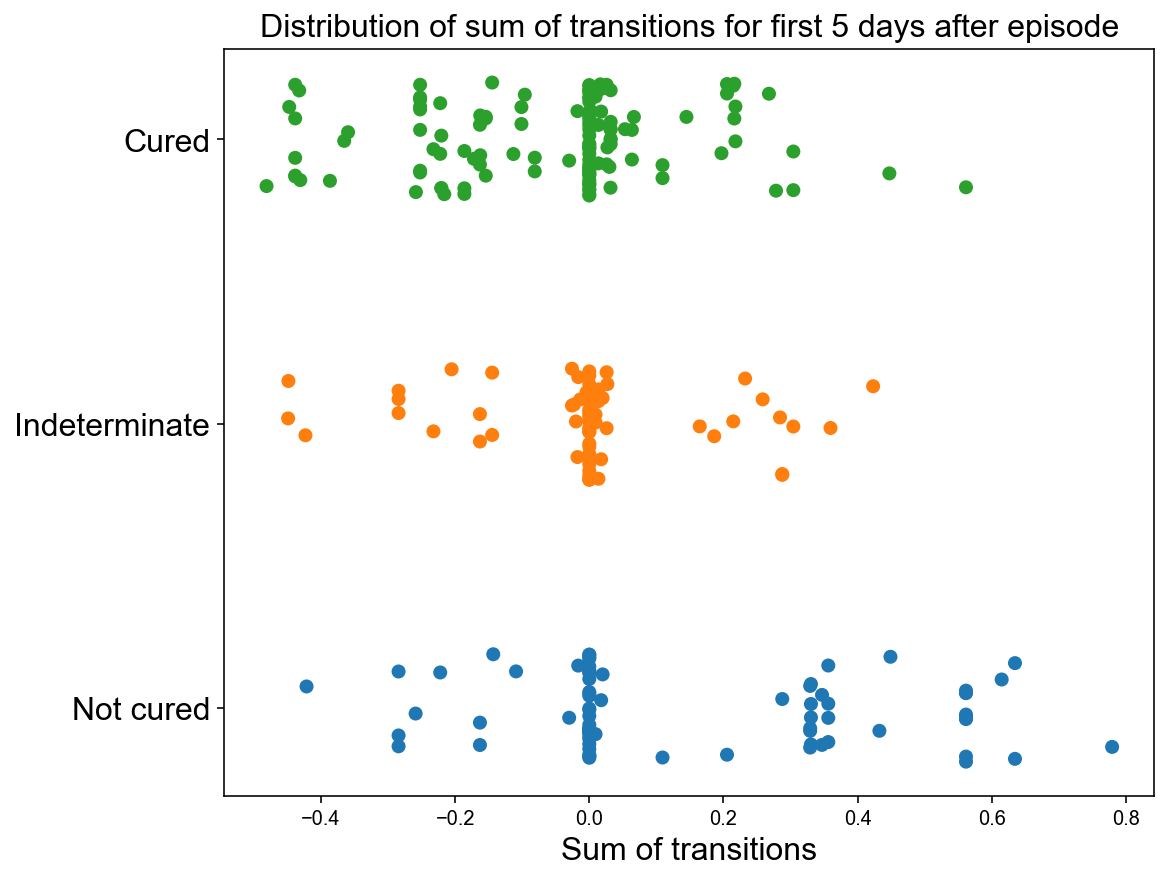

In [30]:
transtion_sums(df, 5);

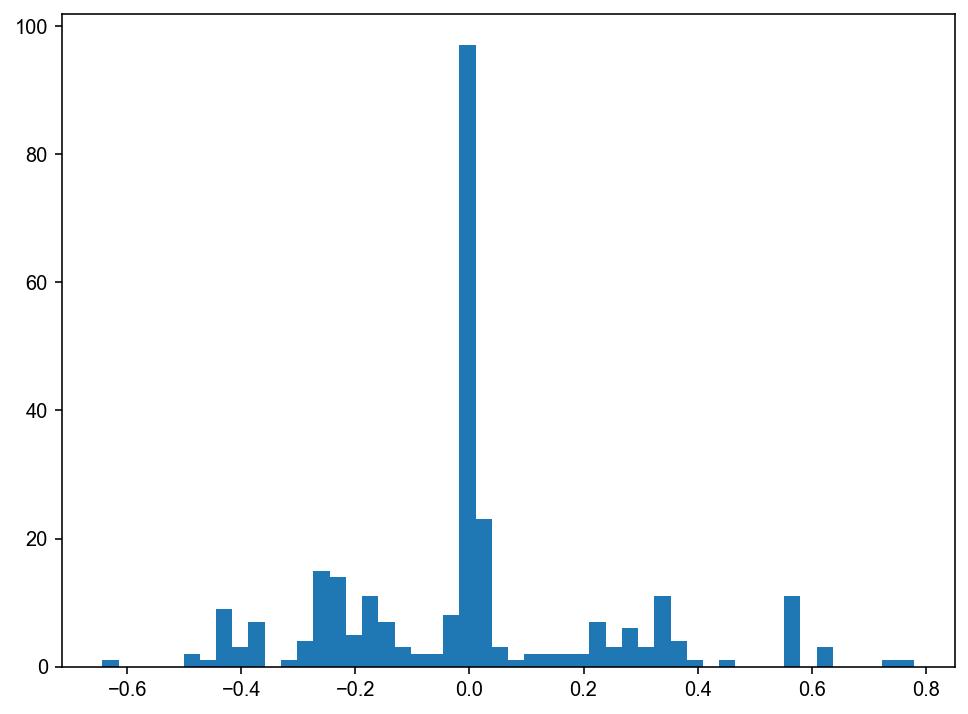

In [31]:
plot_df = df.loc[df.day <= 7]
plot_df = plot_df.groupby(["cured", "episode_start"]).mortality_delta.sum().reset_index()
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(plot_df.mortality_delta, bins=50);

In [32]:
plot_df.loc[plot_df.mortality_delta < -0.1].cured.value_counts()

Cured            61
Indeterminate    13
Not cured        10
Name: cured, dtype: int64

In [33]:
plot_df.loc[
    plot_df.mortality_delta < -0.1
].cured.value_counts() / plot_df.groupby("cured").episode_start.count()

Cured            0.476562
Indeterminate    0.178082
Not cured        0.128205
dtype: float64

In [34]:
plot_df.loc[
    (plot_df.mortality_delta < 0.1)
    & (plot_df.mortality_delta >= -0.1)
].cured.value_counts()

Cured            53
Indeterminate    48
Not cured        34
Name: cured, dtype: int64

In [35]:
plot_df.loc[
    (plot_df.mortality_delta < 0.1)
    & (plot_df.mortality_delta >= -0.1)
].cured.value_counts() / plot_df.groupby("cured").episode_start.count()

Cured            0.414062
Indeterminate    0.657534
Not cured        0.435897
dtype: float64

In [36]:
plot_df.loc[
    (plot_df.mortality_delta >= 0.1)
].cured.value_counts()

Not cured        34
Cured            14
Indeterminate    12
Name: cured, dtype: int64

In [37]:
plot_df.loc[
    (plot_df.mortality_delta >= 0.1)
].cured.value_counts() / plot_df.groupby("cured").episode_start.count()

Cured            0.109375
Indeterminate    0.164384
Not cured        0.435897
dtype: float64

In [38]:
plot_df["delta_group"] = "Low"
plot_df.loc[
    (plot_df.mortality_delta < 0.1) & (plot_df.mortality_delta >= -0.1),
    "delta_group"
] = "Medium"
plot_df.loc[
    (plot_df.mortality_delta >= 0.1),
    "delta_group"
] = "High"

In [39]:
plot_df2 = plot_df.groupby(["delta_group", "cured"]).agg({"cured": "count"}).rename(
    {"cured": "cnt"}, axis="columns"
).reset_index()

In [40]:
plot_df2.cnt /= plot_df.groupby("delta_group").episode_start.count()[plot_df2.delta_group].values

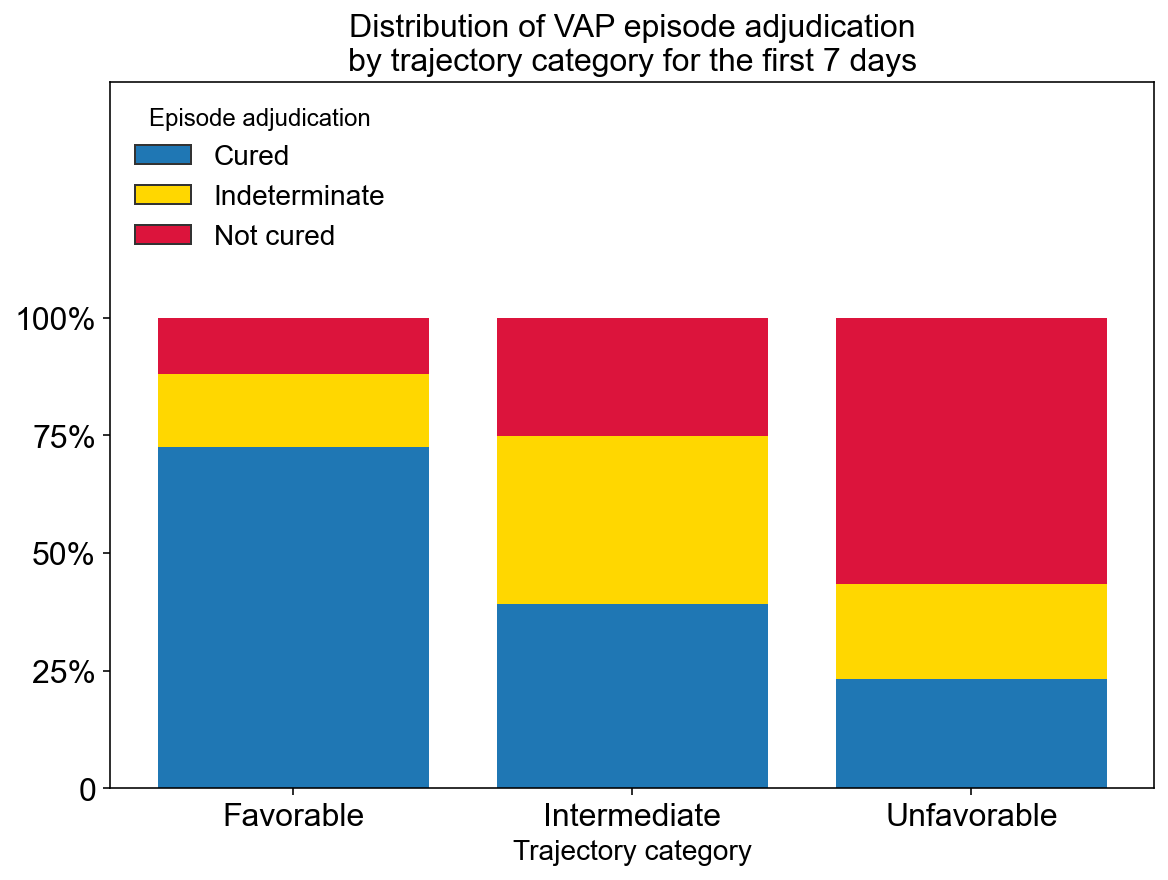

In [41]:
# Stupid seaborn / matplotlib
# I should really submit a pull request to seaborn
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
bottom = np.array([0, 0, 0]).astype(float)
ax.bar([2, 0, 1], plot_df2.cnt[plot_df2.cured.eq("Cured")], 
       color=DISCH_PALETTE[0])
bottom += plot_df2.cnt[plot_df2.cured.eq("Cured")].values
ax.bar([2, 0, 1], plot_df2.cnt[plot_df2.cured.eq("Indeterminate")], 
       color=DISCH_PALETTE[3], bottom=bottom)
bottom += plot_df2.cnt[plot_df2.cured.eq("Indeterminate")].values
ax.bar([2, 0, 1], plot_df2.cnt[plot_df2.cured.eq("Not cured")], 
       color=DISCH_PALETTE[-1], bottom=bottom)
ax.set_xlabel("Trajectory category", size=14)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(
    [
        "Favorable", 
        "Intermediate", 
        "Unfavorable"], 
    size=16
)
# ax.set_ylabel("Percentage of episode adjudication", size=14)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticklabels(["0", "25%", "50%", "75%", "100%"], size=16)
ax.set_ylim(0, 1.5)
ax.set_title(
    "Distribution of VAP episode adjudication\nby trajectory category for the first 7 days",
    size=16
)
handles = [
    mpl.patches.Patch(color=DISCH_PALETTE[0], label="Cured", ec="#333333"),
    mpl.patches.Patch(color=DISCH_PALETTE[3], label="Indeterminate", ec="#333333"),
    mpl.patches.Patch(color=DISCH_PALETTE[-1], label="Not cured", ec="#333333")
]
ax.legend(
    handles=handles, 
    loc="upper left", 
    title="Episode adjudication", 
    frameon=False,
    fontsize=14,
    title_fontsize=12
);
dump_figure("vap_episode_adjudication_by_trajectory.pdf")

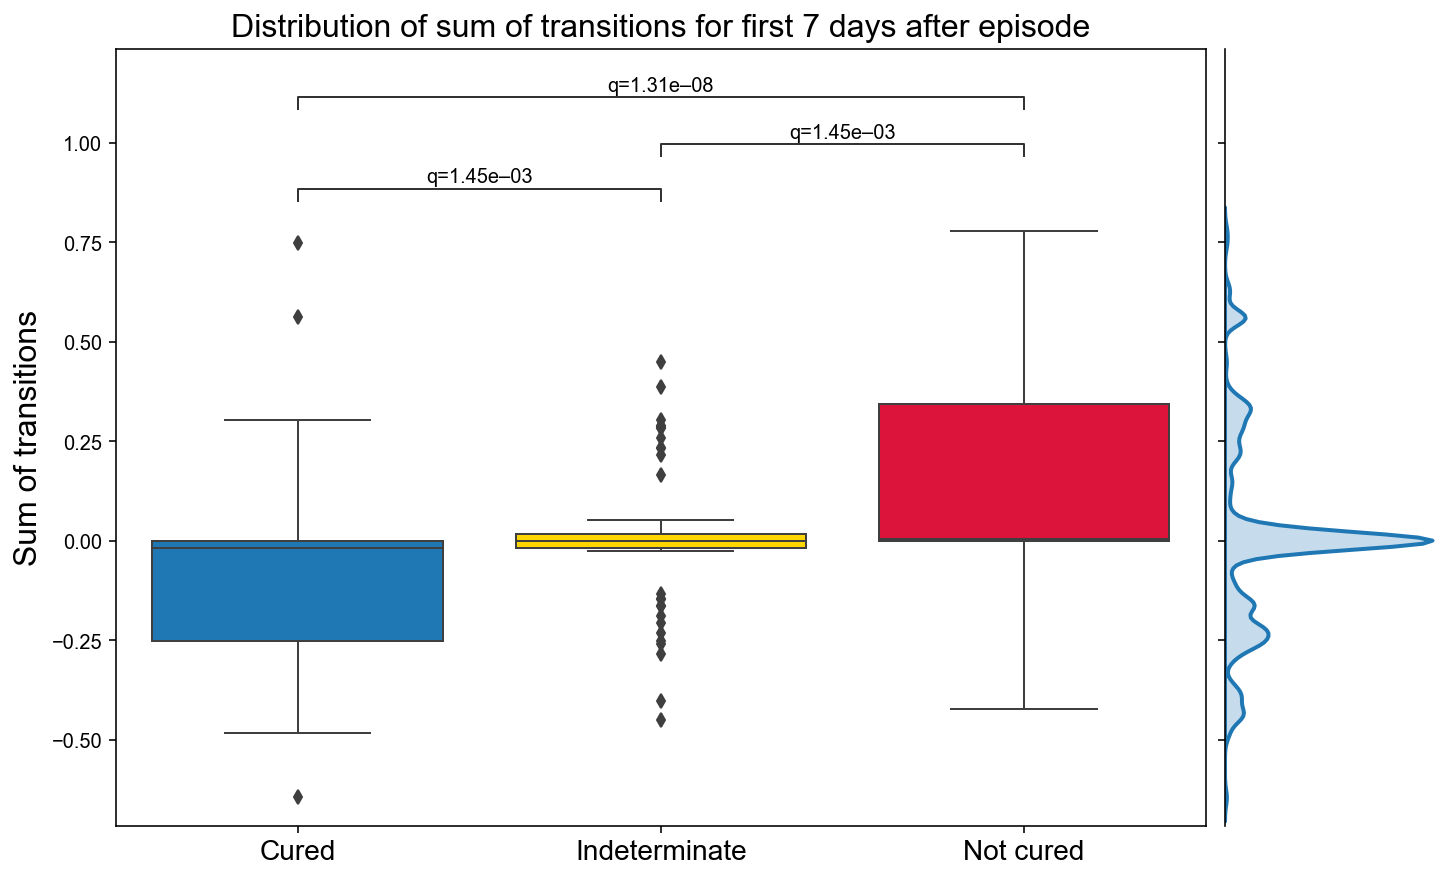

In [42]:
df = df.loc[df.day <= 7]
stat_df = df.groupby(["cured", "episode_start"]).mortality_delta.sum().reset_index()
stat_results = []
for d1, d2 in itertools.combinations(stat_df.cured.unique(), 2):
    days1 = stat_df.mortality_delta[stat_df.cured.eq(d1)]
    days2 = stat_df.mortality_delta[stat_df.cured.eq(d2)]
    if days1.size == 0 or days2.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
    stat_results.append([d1, d2, days1.size, days2.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
    pairs.append((r.group1, r.group2))

fig, axes = plt.subplots(
    ncols=2, 
    figsize=(10, 6), 
    constrained_layout=True,
    sharey=True,
    gridspec_kw={"wspace": 0, "width_ratios": [1, 0.2]}
)
ax = axes[0]
sns.boxplot(
    data=stat_df, 
    x="cured",
    y="mortality_delta", 
    ax=ax, 
    saturation=1, 
    palette=[DISCH_PALETTE[0], DISCH_PALETTE[3], DISCH_PALETTE[-1]],
    linewidth=1
)
for a in ax.collections:
    if isinstance(a, mpl.collections.PatchCollection):
        # remove line surround each box
        a.set_linewidth(0)
ax.set_ylabel("Sum of transitions", size=16)
ax.set_xlabel("")
ax.tick_params(axis="x", labelsize=14)
# ax.set_xticklabels(["non-COVID", "COVID"], size=16)
# ax.legend(loc="upper left", title="Outcome", frameon=False, fontsize=14, title_fontsize=12)
# ax.legend_.set_bbox_to_anchor((1, 0.8))
ax.set_title(f"Distribution of sum of transitions for first {day} days after episode", size=16)
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=stat_df, 
    x="cured",
    y="mortality_delta", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}".replace("-", "–") for x in stat_results_sign.pval_adj])
annotator.annotate();
sns.kdeplot(data=stat_df, y="mortality_delta", ax=axes[1], bw_adjust=0.25, fill=True, lw=2)
axes[1].spines[["top", "right", "bottom"]].set_visible(False)
axes[1].set_xticks([])
axes[1].set_xlabel("");
dump_figure("vap_sum_of_trans_7days_with_side.pdf")

## Look at transitions before VAP and the chance of negative transition

### Baseline

In [43]:
data["bad_transition"] = np.nan

In [44]:
data.loc[data.next_cluster > data.cluster, "bad_transition"] = "bad"

In [45]:
data.loc[data.next_cluster.lt(data.cluster) & data.next_cluster.ne(-1), "bad_transition"] = "good"

In [46]:
data.bad_transition.value_counts(dropna=False)

NaN     9347
bad     1655
good    1493
Name: bad_transition, dtype: int64

Probability of bad transition

In [47]:
data.bad_transition.eq("bad").sum() / data.next_cluster.ne(-1).sum()

0.1410190865712338

Probability of good transition

In [48]:
data.bad_transition.eq("good").sum() / data.next_cluster.ne(-1).sum()

0.12721540558963873

Probability of no transition

In [49]:
data.bad_transition[data.next_cluster.ne(-1)].isna().sum() / data.next_cluster.ne(-1).sum()

0.7317655078391274

### Day -1 before VAP

In [50]:
vap_df = data.loc[data.Episode_category.eq("VAP")].copy()

In [51]:
vap_df["prev_day"] = vap_df.day - 1

In [52]:
vap_df = vap_df.loc[vap_df.prev_day > 0].copy()

In [53]:
vap_df.shape

(311, 80)

In [54]:
data.Episode_category.eq("VAP").sum()

328

Out of 328 VAP episodes we have 311 that have a previous day in the ICU

In [55]:
vap_df["prev_day_idx"] = (
    vap_df.patient.astype(str) 
    + "/" + vap_df.stay.astype(str)
    + "/" + vap_df.day.astype(str)
)

In [56]:
vap_df.prev_day_idx.isin(data.index).sum()

311

In [57]:
day_before_vap = data.loc[vap_df.prev_day_idx]

Probability of bad transition

In [58]:
day_before_vap.bad_transition.eq("bad").sum() / day_before_vap.shape[0]

0.12218649517684887

Probability of good transition

In [59]:
day_before_vap.bad_transition.eq("good").sum() / day_before_vap.shape[0]

0.1414790996784566

### Day -2 before VAP

In [60]:
vap_df = data.loc[data.Episode_category.eq("VAP")].copy()

In [61]:
vap_df["prev_day"] = vap_df.day - 2

In [62]:
vap_df = vap_df.loc[vap_df.prev_day > 0].copy()

In [63]:
vap_df.shape

(284, 80)

In [64]:
data.Episode_category.eq("VAP").sum()

328

Out of 328 VAP episodes we have 284 that have a day -2 in the ICU

In [65]:
vap_df["prev_day_idx"] = (
    vap_df.patient.astype(str) 
    + "/" + vap_df.stay.astype(str)
    + "/" + vap_df.day.astype(str)
)

In [66]:
vap_df.prev_day_idx.isin(data.index).sum()

284

In [67]:
day_before_vap = data.loc[vap_df.prev_day_idx]

Probability of bad transition

In [68]:
day_before_vap.bad_transition.eq("bad").sum() / day_before_vap.shape[0]

0.11971830985915492

Probability of good transition

In [69]:
day_before_vap.bad_transition.eq("good").sum() / day_before_vap.shape[0]

0.13732394366197184

### Day -3 before VAP

In [70]:
vap_df = data.loc[data.Episode_category.eq("VAP")].copy()

In [71]:
vap_df["prev_day"] = vap_df.day - 3

In [72]:
vap_df = vap_df.loc[vap_df.prev_day > 0].copy()

In [73]:
vap_df.shape

(275, 80)

In [74]:
data.Episode_category.eq("VAP").sum()

328

Out of 328 VAP episodes we have 275 that have a day -3 in the ICU

In [75]:
vap_df["prev_day_idx"] = (
    vap_df.patient.astype(str) 
    + "/" + vap_df.stay.astype(str)
    + "/" + vap_df.day.astype(str)
)

In [76]:
vap_df.prev_day_idx.isin(data.index).sum()

275

In [77]:
day_before_vap = data.loc[vap_df.prev_day_idx]

Probability of bad transition

In [78]:
day_before_vap.bad_transition.eq("bad").sum() / day_before_vap.shape[0]

0.12363636363636364

Probability of good transition

In [79]:
day_before_vap.bad_transition.eq("good").sum() / day_before_vap.shape[0]

0.13818181818181818

### For plotting

In [80]:
plot_data = []

In [81]:
plot_data.append((
    "average",
    data.bad_transition.eq("bad").sum() / data.next_cluster.ne(-1).sum(),
    data.bad_transition.eq("good").sum() / data.next_cluster.ne(-1).sum(),
))

In [82]:
for delta in range(8):
    vap_df = data.loc[data.Episode_category.eq("VAP")].copy()
    vap_df["prev_day"] = vap_df.day - delta
    vap_df = vap_df.loc[vap_df.prev_day > 0].copy()
    vap_df["prev_day_idx"] = (
        vap_df.patient.astype(str) 
        + "/" + vap_df.stay.astype(str)
        + "/" + vap_df.day.astype(str)
    )
    vap_df.prev_day_idx.isin(data.index).sum()
    day_before_vap = data.loc[vap_df.prev_day_idx]
    bad_prob = day_before_vap.bad_transition.eq("bad").sum() / day_before_vap.shape[0]
    good_prob = day_before_vap.bad_transition.eq("good").sum() / day_before_vap.shape[0]
    plot_data.append((
        f"day -{delta}\n(n={vap_df.shape[0]})",
        bad_prob,
        good_prob
    ))

In [83]:
plot_df = pd.DataFrame(plot_data, columns=["category", "bad_prob", "good_prob"])

In [84]:
plot_df["no_prob"] = 1 - plot_df.bad_prob - plot_df.good_prob

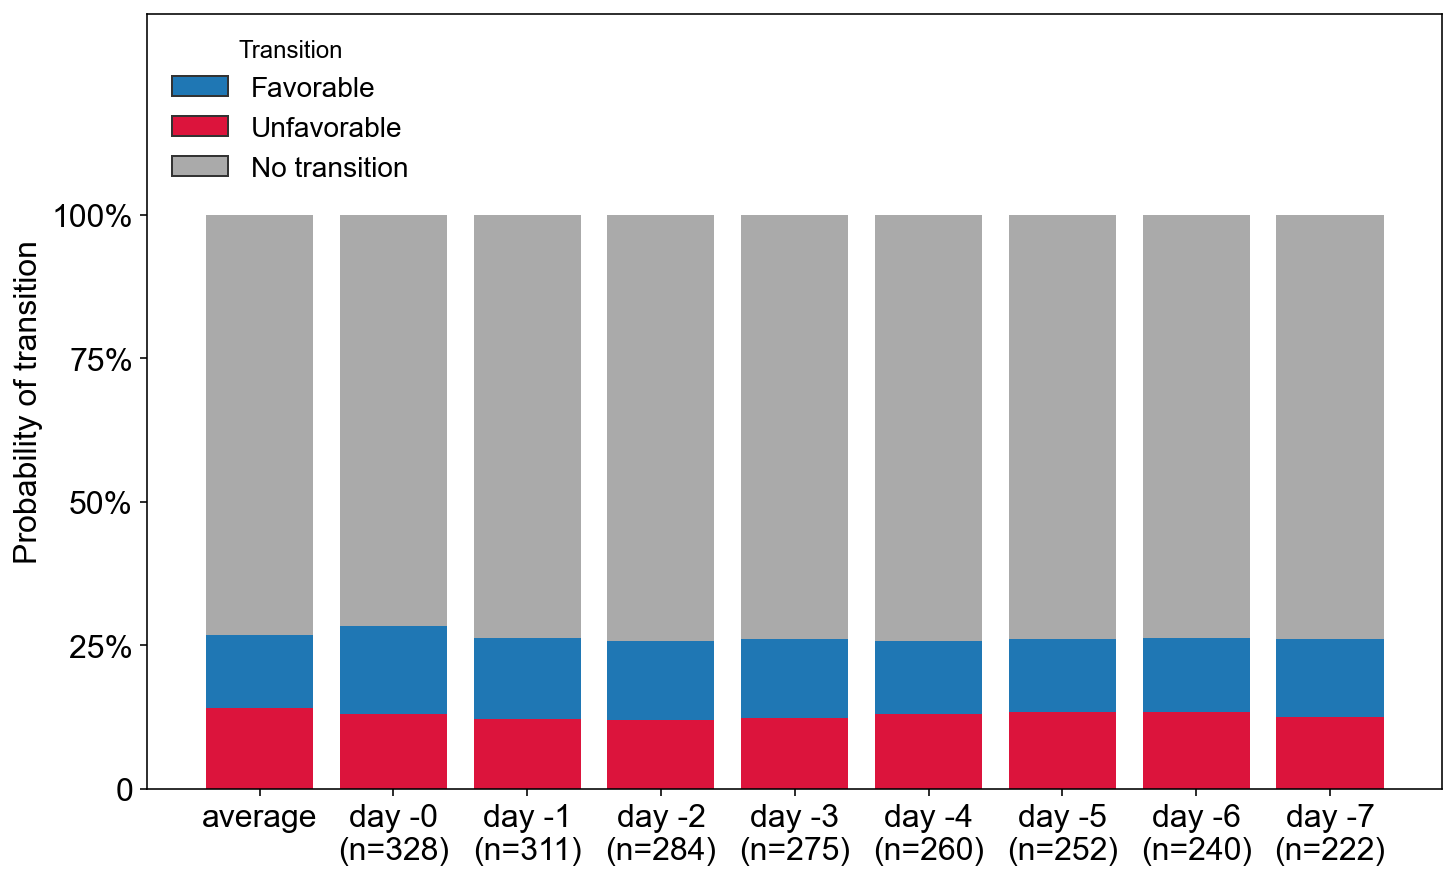

In [85]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
ax.bar(plot_df.index, plot_df.bad_prob, color=DISCH_PALETTE[-1])
ax.bar(plot_df.index, plot_df.good_prob, color=DISCH_PALETTE[0], bottom=plot_df.bad_prob)
ax.bar(plot_df.index, plot_df.no_prob, color="#aaa", bottom=plot_df.bad_prob + plot_df.good_prob)
ax.set_xticks(list(range(9)))
ax.set_xticklabels(plot_df.category, size=16)
ax.set_ylabel("Probability of transition", size=16)
ax.set_ylim(0, 1.35)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticklabels(["0", "25%", "50%", "75%", "100%"], size=16)
handles = [
    mpl.patches.Patch(color=DISCH_PALETTE[0], label="Favorable", ec="#333333"),
    mpl.patches.Patch(color=DISCH_PALETTE[-1], label="Unfavorable", ec="#333333"),
    mpl.patches.Patch(color="#aaa", label="No transition", ec="#333333")
]
ax.legend(
    handles=handles, 
    loc="upper left", 
    title="Transition", 
    frameon=False,
    fontsize=14,
    title_fontsize=12
);


dump_figure("transition_probability_pre7.pdf")